In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import scipy.stats
from IPython.display import Video, display, HTML
import re
from colour import Color
from collections import defaultdict

sns.set()


def gethighest(vals, prefix="logall_"):
        m = np.argmax([int(re.search(f'{prefix}(\d+)', val).group(1)) for val in vals])
        return vals[m]

def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)
    except FileNotFoundError as e:
        return pd.read_csv(str(path), *args, **kwargs)

        
def readparams(file):
    params = {} 
    with open(file) as f:
        for line in f:
            line = line[:-1]  # remove \n
            if not line or line.startswith('#') or line.startswith('import'):
                continue
            key, val = line.split('=')
            if val.lower() == 'true' or val.lower() == 'false':
                params[key] = val.lower() == 'true'
            else:
                try:
                    params[key] = float(val)
                except ValueError:
                    params[key] = val
    return params

In [2]:
%config InlineBackend.figure_format = 'svg'


In [3]:
%matplotlib inline
sns.set_context('paper')
sns.set_style('white')

## Colors
coopColor = Color("#3375b2")
dotcolor = coopColor
dotcolor.luminance *= 1.2
defectColor = Color("#963d35")
badtoomany = Color("#963d35")
badtoomany.luminance = 0.9
badnotenough = Color("#963d35")
badnotenough.luminance *= 1
good = Color("#75a7d7")
toofew = Color("#ead8d6")
perfect = Color("#e3edf7")
toomany = Color("#fdf8f8")



## Helpers
def plot_ess(data, *args, **kwargs):
    nopti = data['nOpti'].mean()
    try:
        a = data['meanA'].iloc[0]
    except Exception:
        a = 5
    opt = dict(c=defectColor.hex, label="ESS", linestyle='-.')
    opt.update(kwargs)
    plt.axhline(a, *args, **opt)
    
def plot_so(data, *args, **kwargs):
    nopti = data['nOpti'].mean()
    try:
        a = data['meanA'].iloc[0]
    except Exception:
        a = 5
    try:
        b = data['b'].iloc[0]
    except Exception:
        b = 10
    opt = dict(c=coopColor.hex, label="SO", linestyle='--')
    opt.update(kwargs)
    plt.axhline(a + b, *args, **opt)
    
def plot_span(data, *args, **kwargs):
    nhat = data['nOpti'].mean()
    omega = data['gNbOfPhysicalObjects'].mean()
    maxmaxplayer = data['maxPlayer'].max()
    labels=defaultdict(lambda: None)
    if kwargs.get('label', True):
        labels['ind'] = "Too few individuals"
        labels['good'] = "Possible partner choice"
        labels['patch'] = "Too few patches"
    vs = plt.axvspan(0, nhat+1, color=toofew.hex, label=labels['ind'])
    vs.set_zorder(0)
    vs = plt.axvspan(nhat+1, min(nhat*omega+1, maxmaxplayer), color=perfect.hex, label=labels['good'])
    vs.set_zorder(0)
    vs = plt.axvspan(min(nhat*omega+1, maxmaxplayer), maxmaxplayer, color=toomany.hex, label=labels['patch'])
    vs.set_zorder(0)

    
def plot_span_omega(data, *args, **kwargs):

    nhat = data['nOpti'].iloc[0]
    maxplayer = data['maxPlayer'].iloc[0]
    sigma = data['nTolerance'].iloc[0]
    labels=defaultdict(lambda: None)
    if kwargs.get('label', True):
        labels['ind'] = "Too few individuals"
        labels['good'] = "Possible partner choice"
        labels['patch'] = "Too few patches"
    if sigma < 1e20:
        vs = plt.axvspan(maxplayer // nhat, maxplayer + 2, color=perfect.hex, label=labels['good'])
        vs.set_zorder(0)
        vs = plt.axvspan(0, maxplayer // nhat, color=toomany.hex, label=labels['patch'])
        vs.set_zorder(0)
    else:
        vs = plt.axvspan(0, maxplayer + 2, color=perfect.hex, label=labels['good'])
        vs.set_zorder(0)

def annotator(itera, *args, s=10, **kwargs):
    plt.text(-0.05, 1.05, next(itera) + '.', transform=plt.gca().transAxes, 
            size=size, weight='bold')


end of preamble


# Load File

In [4]:
runname = 'lionscross24-mean5paperready'
dfful = pd.read_pickle(f'all_file_loaded_{runname}.pkl.gz')
#dfcond = dfful.query('nOpti == 2 or nOpti == 3')


In [5]:
dfful['nTolerance'].unique()

array([1.0e+00, 1.0e-01, 5.0e-01, 1.5e+00, 2.0e+00, 1.0e+25, 3.0e+00])

In [6]:
tol = 1
b = 5

omegas = [20, 40, 80]
maxpop = dfful['maxPlayer'].max()
objwhenmaxplayerx = 20

print(maxpop)

y = 'truecoopmod'
ylabel='Mean investment for modal n'

dfcond = dfful.query('nTolerance == @tol and gNbOfPhysicalObjects in @omegas and b == @b and cost == 0').copy()
assert(dfcond['b'].nunique() == 1)
tolstr = str(tol) if tol < 1e20 else 'inf'

print(dfful['nTolerance'].unique())
print(dfful['gNbOfPhysicalObjects'].unique())
print('costs:', dfful['cost'].unique())
print('maxpop:', maxpop)

100.0
[1.0e+00 1.0e-01 5.0e-01 1.5e+00 2.0e+00 1.0e+25 3.0e+00]
[100.  10.  20.  30.  40.  50.  60.  70.  80.  90.]
costs: [1000.  100.   10.    0.]
maxpop: 100.0


NameError: name 'size' is not defined

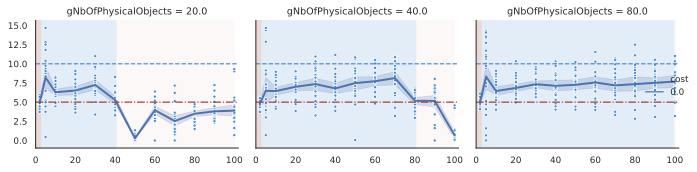

In [7]:
import string
import os
sns.set_context('paper')
maxplayer = dfcond['maxPlayer'].max()
g = sns.relplot(data=dfcond.query('nOpti == 2 and gNbOfPhysicalObjects in @omegas and cost in [0, 10, 100, 1000]'), col="gNbOfPhysicalObjects",
                x="maxPlayer", y=y , kind="line", hue='cost',
                facet_kws={'xlim':(0, maxplayer + 2), 'sharey': True, 'legend_out': True}, aspect=1.2, height=2.5, lw=2)
g.map_dataframe(sns.scatterplot, x="maxPlayer", y=y, s=10, color=dotcolor.hex)
#g.map_dataframe(sns.scatterplot, x="maxPlayer", y=y, s=10, color=coopColor.hex)

g.map_dataframe(plot_ess)
g.map_dataframe(plot_so)
g.map_dataframe(plot_span)
g.map(annotator, itera=iter(string.ascii_uppercase))
g.set(ylabel=ylabel, xlabel="Number of individuals")
g.set_titles("$\omega = {col_name}$")

#g.set_xlabel('Number of agents in the environment')
g.add_legend()
os.makedirs(f'out/{runname}', exist_ok=True)
g.savefig(f'out/{runname}/varNrowOpp_{tolstr}.pdf')
plt.show()

In [ ]:
sns.set_context('paper')
g = sns.relplot(data=dfcond.query('gNbOfPhysicalObjects >= 20 and nOpti < 10 and nOpti == 2'), hue="cost", col="gNbOfPhysicalObjects", x="maxPlayer", y=y , kind="line",
                facet_kws={'xlim': (0, maxplayer + 2), 'ylim': {0, 15}}, aspect=1.2, height=2.5, lw=2)

#g.map_dataframe(sns.scatterplot, color="green", x="maxPlayer", y=y)
g.map_dataframe(sns.scatterplot, x="maxPlayer", y=y, s=10, color=dotcolor.hex)
g.map_dataframe(plot_ess)
g.map_dataframe(plot_so)
g.map_dataframe(plot_span)
g.map(annotator, itera=iter(string.ascii_uppercase))

g.set_titles('$\omega = {col_name}$')
g.set(ylabel=ylabel, xlabel="Number of agents in the environment")
g.add_legend()
g.savefig(f'out/{runname}/colobj_popx_{tolstr}.pdf')


In [ ]:
sns.set_context('paper')
g = sns.relplot(data=dfcond.query('nOpti < 10 and gNbOfPhysicalObjects == 40'), hue='cost', col="nOpti", x="maxPlayer", y=y , kind="line",
                facet_kws={'ylim': {0, 15}, 'xlim':(0, maxplayer + 2)}, aspect=1.2, height=2.5, lw=2)

#g.map_dataframe(sns.scatterplot, color="green", x="maxPlayer", y=y)
g.map_dataframe(sns.scatterplot, x="maxPlayer", y=y, s=10, color=dotcolor.hex)
g.map_dataframe(plot_ess)
g.map_dataframe(plot_so)
g.map_dataframe(plot_span)
g.map(annotator, itera=iter(string.ascii_uppercase))

g.set_titles(r'$\hat{{n}} = {col_name}$')
g.set(ylabel=ylabel, xlabel="Number of agents in the environment")
g.add_legend()
g.savefig(f'out/{runname}/coln_popx_{tolstr}.pdf')


In [ ]:
sns.set_context('paper')
g = sns.relplot(data=dfcond.query('gNbOfPhysicalObjects >= 20 and nOpti < 10'), col="gNbOfPhysicalObjects", row="nOpti", x="maxPlayer", y=y , kind="line",
                facet_kws={'ylim': {0, 15}, 'xlim':(0, maxplayer + 2)}, aspect=1.2, height=2.5, lw=2)

#g.map_dataframe(sns.scatterplot, color="green", x="maxPlayer", y=y)
g.map_dataframe(sns.scatterplot, x="maxPlayer", y=y, s=10, color=dotcolor.hex)
g.map_dataframe(plot_ess)
g.map_dataframe(plot_so)
g.map_dataframe(plot_span)
#g.map(annotator, itera=iter(string.ascii_uppercase))

g.set_titles('$\hat{{n}} = {row_name}$ | $\omega = {col_name}$')
g.set(ylabel=ylabel, xlabel="Number of agents in the environment")
g.add_legend()
g.savefig(f'out/{runname}/grid_{tolstr}.pdf')


In [ ]:
dfful['nOpti'].unique()

In [ ]:
# AJOUTER EXPÉRIENCE CONTRÔLE SANS VISION

In [ ]:
import matplotlib as mpl

def add_legend(self, legend_data=None, title=None, label_order=None,
               **kwargs):
    """Draw a legend, maybe placing it outside axes and resizing the figure.

    Parameters
    ----------
    legend_data : dict, optional
        Dictionary mapping label names (or two-element tuples where the
        second element is a label name) to matplotlib artist handles. The
        default reads from ``self._legend_data``.
    title : string, optional
        Title for the legend. The default reads from ``self._hue_var``.
    label_order : list of labels, optional
        The order that the legend entries should appear in. The default
        reads from ``self.hue_names``.
    kwargs : key, value pairings
        Other keyword arguments are passed to the underlying legend methods
        on the Figure or Axes object.

    Returns
    -------
    self : Grid instance
        Returns self for easy chaining.

    """
    # Find the data for the legend
    if legend_data is None:
        legend_data = self._legend_data
    if label_order is None:
        if self.hue_names is None:
            label_order = list(legend_data.keys())
        else:
            label_order = list(map(utils.to_utf8, self.hue_names))

    blank_handle = mpl.patches.Patch(alpha=0, linewidth=0)
    handles = [legend_data.get(l, blank_handle) for l in label_order]
    title = self._hue_var if title is None else title
    try:
        title_size = mpl.rcParams["axes.labelsize"] * .85
    except TypeError:  # labelsize is something like "large"
        title_size = mpl.rcParams["axes.labelsize"]

    # Unpack nested labels from a hierarchical legend
    labels = []
    for entry in label_order:
        if isinstance(entry, tuple):
            _, label = entry
        else:
            label = entry
        labels.append(label)

    # Set default legend kwargs
    kwargs.setdefault("scatterpoints", 1)

    if self._legend_out:

        kwargs.setdefault("frameon", False)
        kwargs.setdefault("loc", "lower center")

        # Draw a full-figure legend outside the grid
        figlegend = self.fig.legend(handles, labels, **kwargs)

        self._legend = figlegend
        figlegend.set_title(title, prop={"size": title_size})

        # Draw the plot to set the bounding boxes correctly
        if hasattr(self.fig.canvas, "get_renderer"):
            self.fig.draw(self.fig.canvas.get_renderer())

        # Calculate and set the new width of the figure so the legend fits
        legend_height = figlegend.get_window_extent().height / self.fig.dpi
        fig_width, fig_height = self.fig.get_size_inches()
        self.fig.set_size_inches(fig_width, fig_height + legend_height)

        # Draw the plot again to get the new transformations
        if hasattr(self.fig.canvas, "get_renderer"):
            self.fig.draw(self.fig.canvas.get_renderer())

        # Now calculate how much space we need on the bottom side
        legend_height = figlegend.get_window_extent().height / self.fig.dpi
        space_needed = legend_height / (fig_height + legend_height)
        margininch = 0.7
        margin = margininch / (fig_height + margininch)
        self._space_needed = margin + space_needed
        bottom = self._space_needed

        # Place the subplot axes to give space for the legend
        self.fig.subplots_adjust(bottom=bottom)

    else:
        # Draw a legend in the first axis
        ax = self.axes.flat[0]
        kwargs.setdefault("loc", "best")

        leg = ax.legend(handles, labels, **kwargs)
        leg.set_title(title, prop={"size": title_size})

    return self

In [ ]:
sns.set_context('paper')
#plt.figure(figsize=(5, 6/10*5))
dfobjvar=dfful.query('maxPlayer == @maxpop and nTolerance in [1, 1e25] and b == @b and cost == 0').copy()
assert(dfobjvar['b'].nunique() == 1)
noptis = [2, 3]
dfobjvar['objvarcond'] = None
dfobjvar['objvarcond'] = np.where(dfobjvar.eval('nOpti <= 4'), 
                                  dfobjvar['nOpti'].apply(lambda x: rf'$\hat{{n}} = {x}$'), dfobjvar['objvarcond'])
dfobjvar['objvarcond'] = np.where(dfobjvar.eval('nTolerance > 1e20 and nOpti == 2'), r'$\sigma \to \infty$', dfobjvar['objvarcond'])
allconds = sorted([cond for cond in dfobjvar['objvarcond'].unique() if cond is not None])

g = sns.relplot(data=dfobjvar, col="objvarcond", x="gNbOfPhysicalObjects", y=y , kind="line", col_wrap=2,
                aspect=1.2, height=2.5, col_order=allconds, facet_kws={'legend_out': True, 'xlim':(0, maxplayer + 2)}, lw=2)
g.map_dataframe(sns.scatterplot, x="gNbOfPhysicalObjects", y=y, s=10, color=dotcolor.hex)

g.map_dataframe(plot_so)
g.map_dataframe(plot_ess)
g.map_dataframe(plot_span_omega)
g.map(annotator, itera=iter(string.ascii_uppercase))
g.set(ylabel=ylabel, xlabel="Number of patches $\omega$")
g.set(xlim=(0, maxpop+1))
g.set_titles("{col_name}")
plt.tight_layout()
add_legend(g, ncol=4, loc='lower center')

plt.savefig(f'out/{runname}/varopp_hatn_{tolstr}.pdf')

In [ ]:
sns.set_context('paper')
#plt.figure(figsize=(5, 6/10*5))
dfobjvar=dfful.query('maxPlayer == @maxpop and nOpti == 2 and b == @b and cost == 0 and nTolerance != 1 and nTolerance < 1e20').copy()
assert(dfobjvar['b'].nunique() == 1)
g = sns.relplot(data=dfobjvar, col="nTolerance", x="gNbOfPhysicalObjects", y=y , kind="line", col_wrap=2,
                aspect=1.2, height=2.5, facet_kws={'legend_out': True, 'xlim':(0, maxplayer + 2)}, lw=2)
g.map_dataframe(sns.scatterplot, x="gNbOfPhysicalObjects", y=y, s=10, color=dotcolor.hex)

g.map_dataframe(plot_so)
g.map_dataframe(plot_ess)
g.map_dataframe(plot_span_omega)
g.map(annotator, itera=iter(string.ascii_uppercase))
g.set(ylabel=ylabel, xlabel="Number of patches $\omega$")
g.set(xlim=(0, maxpop+1))
g.set_titles("$\sigma =$ {col_name}")
plt.tight_layout()
add_legend(g, ncol=4, loc='lower center')

plt.savefig(f'out/{runname}/tol_grid.pdf')
#dfful.query('maxPlayer == @maxpop and nOpti == 2 and b == @b and cost == 0 and gNbOfPhysicalObjects == 80 and nTolerance == 1').count()

In [ ]:
sns.set_context('paper')
#plt.figure(figsize=(5, 6/10*5))
dfobjvar=dfful.query('maxPlayer == @maxpop and nOpti == 2 and b == @b and nTolerance == @tolstr and cost in [10, 100]').copy()
assert(dfobjvar['b'].nunique() == 1)
assert(all(dfobjvar.groupby(['cost', 'gNbOfPhysicalObjects'])['coopabove2'].count() == 24))
g = sns.relplot(data=dfobjvar, col="cost", x="gNbOfPhysicalObjects", y=y , kind="line", col_wrap=2,
                aspect=1.2, height=2.5, facet_kws={'legend_out': True})
g.map_dataframe(sns.scatterplot, x="gNbOfPhysicalObjects", y=y, s=10, color=dotcolor.hex)

g.map_dataframe(plot_so)
g.map_dataframe(plot_ess)
g.map_dataframe(plot_span_omega)
g.map(annotator, itera=iter(string.ascii_uppercase))
g.set(ylabel=ylabel, xlabel="Number of patches $\omega$")
g.set(xlim=(0, maxpop+1))
g.set_titles("cost = {col_name}")
plt.tight_layout()
add_legend(g, ncol=4, loc='lower center')

plt.savefig(f'out/{runname}/cost_grid_{tolstr}.pdf')
#dfful.query('maxPlayer == @maxpop and nOpti == 2 and b == @b and cost == 0 and gNbOfPhysicalObjects == 80 and nTolerance == 1').count()

In [ ]:
import string
sns.set_context('paper')
g = sns.relplot(data=dfcond.query('nOpti == 2 and gNbOfPhysicalObjects == @objwhenmaxplayerx'), col="gNbOfPhysicalObjects", x="maxPlayer", y=y , kind="line",
                facet_kws={'sharey': True, 'legend_out': True, 'xlim':(0, maxplayer + 2)}, aspect=1.7, height=3, lw=2)
g.map_dataframe(sns.scatterplot, x="maxPlayer", y=y, s=10, color=dotcolor.hex)
#g.map_dataframe(sns.scatterplot, x="maxPlayer", y=y, s=10, color=coopColor.hex)

g.map_dataframe(plot_ess,  color=defectColor.hex, label="defect investment")
g.map_dataframe(plot_so,  color=coopColor.hex, label="social optimum investment")
g.map_dataframe(plot_span)
#g.map(annotator, itera=iter(string.ascii_uppercase))
g.set(ylabel=ylabel, xlabel="Number of agents in the environment")
g.set_titles("$\omega = {col_name}$")

#g.set_xlabel('Number of agents in the environment')
g.add_legend()
#plt.tight_layout()
g.savefig(f'out/{runname}/varNrowOpp_{tolstr}.pdf')
plt.show()

In [ ]:
import string
opps = [20, 40, 80]
g = sns.relplot(data=dfcond.query('nOpti == 2 and gNbOfPhysicalObjects in @opps'), col="gNbOfPhysicalObjects", x="maxPlayer", y=y , kind="line",
                facet_kws={'ylim':(-0.5, 12.5), 'xlim':(0, maxplayer + 2), 'sharey': True, 'legend_out': True}, aspect=1.2, height=3, lw=2)
g.map_dataframe(sns.scatterplot , x="maxPlayer", y=y, s=10, color=dotcolor.hex, label=None)
#g.map_dataframe(sns.scatterplot, x="maxPlayer", y=y, s=10, color=coopColor.hex)

g.map_dataframe(plot_ess)
g.map_dataframe(plot_so)
g.map_dataframe(plot_span)
g.map(annotator, itera=iter(string.ascii_uppercase))
g.set(ylabel=ylabel, xlabel="Number of individuals")
g.set_titles("$\omega = {col_name}$")

#g.set_xlabel('Number of agents in the environment')
add_legend(g, ncol=5, loc="lower center")
g.savefig(f'out/{runname}/varNrowOpp_{tolstr}.pdf')
plt.show()



In [ ]:
g._facet_plot??

In [ ]:
import string
opps = [40]
g = sns.relplot(data=dfcond.query('nOpti == 2 and gNbOfPhysicalObjects in @opps'), col="gNbOfPhysicalObjects", x="maxPlayer", y=y , kind="line",
                facet_kws={'ylim':(-0.5, 12.5), 'xlim':(0, maxplayer + 2), 'sharey': True, 'legend_out': False}, aspect=1.2, height=3, lw=2)
g.map_dataframe(sns.scatterplot, x="maxPlayer", y=y, s=10, color=dotcolor.hex)
#g.map_dataframe(sns.scatterplot, x="maxPlayer", y=y, s=10, color=coopColor.hex)

g.map_dataframe(plot_ess)
g.map_dataframe(plot_so)
g.map_dataframe(plot_span, label=False)
g.map(annotator, itera=iter(string.ascii_uppercase))
g.set(ylabel=ylabel, xlabel="Number of individuals")
g.set_titles("$\omega = {col_name}$")

#g.set_xlabel('Number of agents in the environment')
g.add_legend()
g.savefig(f'out/{runname}/varN_{tolstr}.pdf')
plt.show()

In [ ]:
from scipy.stats import ttest_1samp
print(len(dfcond.query('gNbOfPhysicalObjects == 10 and maxPlayer == 10 and nOpti == 2')))
ttest_1samp(dfcond.query('gNbOfPhysicalObjects == 10 and maxPlayer == 10 and nOpti == 2')[y], 5)

In [ ]:
len(dfcond.query('nOpti == 2 and gNbOfPhysicalObjects == 10 and maxPlayer == 100'))

In [ ]:
df = pd.read_pickle('all_file_loaded_lionscross24-mean5paperready.pkl.gz')

In [ ]:
print()

In [ ]:
print([col for col in df.columns if len(df[col].unique()) > 1])

In [ ]:
from pprint import pprint
d = dict()
for elem in ['maxPlayer', 'gNbOfPhysicalObjects', 'nOpti', 'nTolerance']:
    d.update({elem: sorted([int(x) if float(x).is_integer() and x < 1e10 else x for x in df[elem].unique()])})
pprint(d)

In [128]:
df[]

SyntaxError: invalid syntax (<ipython-input-128-71f11347ebfc>, line 1)